# Лабораторная работа №5: Градиентный бустинг (Gradient Boosting)

**Цель работы:** Изучить алгоритм градиентного бустинга и применить его для решения задач классификации и регрессии. Сравнить результаты всех алгоритмов из лабораторных работ 1-5.


## Импорт библиотек


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    mean_absolute_error, mean_squared_error, r2_score
)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline


## Загрузка и предобработка данных


In [2]:
# Загрузка данных для классификации
stroke_data = pd.read_csv('../data/healthcare-dataset-stroke-data.csv')

print("=" * 60)
print("ДАТАСЕТ ДЛЯ КЛАССИФИКАЦИИ (Stroke Prediction)")
print("=" * 60)
print(f"Размер: {stroke_data.shape}")
print(f"\nПервые строки:")
print(stroke_data.head())

# Анализ баланса классов
stroke_counts = stroke_data['stroke'].value_counts()
print(f"\nРаспределение классов:")
print(f"  - Нет инсульта (0): {stroke_counts[0]} ({stroke_counts[0]/len(stroke_data)*100:.1f}%)")
print(f"  - Инсульт (1):      {stroke_counts[1]} ({stroke_counts[1]/len(stroke_data)*100:.1f}%)")


ДАТАСЕТ ДЛЯ КЛАССИФИКАЦИИ (Stroke Prediction)
Размер: (5110, 12)

Первые строки:
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  

In [3]:
# Предобработка данных для классификации
stroke_processed = stroke_data.copy()

# Удаление id
stroke_processed = stroke_processed.drop('id', axis=1)

# Обработка пропущенных значений
stroke_processed['bmi'].fillna(stroke_processed['bmi'].median(), inplace=True)

# Кодирование категориальных признаков
le = LabelEncoder()
for col in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    stroke_processed[col] = le.fit_transform(stroke_processed[col])

# Разделение на признаки и целевую переменную
X_clf = stroke_processed.drop('stroke', axis=1)
y_clf = stroke_processed['stroke']

# Разделение на train/test
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

print("Данные для классификации подготовлены:")
print(f"  Train: {X_train_clf.shape}")
print(f"  Test:  {X_test_clf.shape}")


Данные для классификации подготовлены:
  Train: (4088, 10)
  Test:  (1022, 10)


In [4]:
# Загрузка данных для регрессии
insurance_data = pd.read_csv('../data/insurance.csv')

print("=" * 60)
print("ДАТАСЕТ ДЛЯ РЕГРЕССИИ (Insurance Cost)")
print("=" * 60)
print(f"Размер: {insurance_data.shape}")
print(f"\nПервые строки:")
print(insurance_data.head())
print(f"\nСтатистика целевой переменной:")
print(insurance_data['charges'].describe())


ДАТАСЕТ ДЛЯ РЕГРЕССИИ (Insurance Cost)
Размер: (1338, 7)

Первые строки:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Статистика целевой переменной:
count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64


In [5]:
# Предобработка данных для регрессии
insurance_processed = insurance_data.copy()

# Кодирование категориальных признаков
insurance_processed['sex'] = le.fit_transform(insurance_processed['sex'])
insurance_processed['smoker'] = le.fit_transform(insurance_processed['smoker'])
insurance_processed['region'] = le.fit_transform(insurance_processed['region'])

# Разделение на признаки и целевую переменную
X_reg = insurance_processed.drop('charges', axis=1)
y_reg = insurance_processed['charges']

# Разделение на train/test
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print("Данные для регрессии подготовлены:")
print(f"  Train: {X_train_reg.shape}")
print(f"  Test:  {X_test_reg.shape}")


Данные для регрессии подготовлены:
  Train: (1070, 6)
  Test:  (268, 6)


## 2. Создание бейзлайна и оценка качества

Обучим базовые модели Gradient Boosting из sklearn для обеих задач.


### 2.1. Классификация (Baseline)


In [6]:
# Обучение базовой модели Gradient Boosting для классификации
clf_baseline = GradientBoostingClassifier(random_state=42)
clf_baseline.fit(X_train_clf, y_train_clf)

# Предсказания
y_train_pred_clf = clf_baseline.predict(X_train_clf)
y_test_pred_clf = clf_baseline.predict(X_test_clf)

# Метрики
print("=" * 60)
print("BASELINE: Gradient Boosting Classifier")
print("=" * 60)
print("\nМетрики на обучающей выборке:")
print(f"  Accuracy:  {accuracy_score(y_train_clf, y_train_pred_clf):.4f}")
print(f"  Precision: {precision_score(y_train_clf, y_train_pred_clf):.4f}")
print(f"  Recall:    {recall_score(y_train_clf, y_train_pred_clf):.4f}")
print(f"  F1-Score:  {f1_score(y_train_clf, y_train_pred_clf):.4f}")

print("\nМетрики на тестовой выборке:")
print(f"  Accuracy:  {accuracy_score(y_test_clf, y_test_pred_clf):.4f}")
print(f"  Precision: {precision_score(y_test_clf, y_test_pred_clf):.4f}")
print(f"  Recall:    {recall_score(y_test_clf, y_test_pred_clf):.4f}")
print(f"  F1-Score:  {f1_score(y_test_clf, y_test_pred_clf):.4f}")

print(f"\nПараметры модели:")
print(f"  n_estimators: {clf_baseline.n_estimators}")
print(f"  learning_rate: {clf_baseline.learning_rate}")
print(f"  max_depth: {clf_baseline.max_depth}")


BASELINE: Gradient Boosting Classifier

Метрики на обучающей выборке:
  Accuracy:  0.9596
  Precision: 1.0000
  Recall:    0.1709
  F1-Score:  0.2918

Метрики на тестовой выборке:
  Accuracy:  0.9501
  Precision: 0.4000
  Recall:    0.0400
  F1-Score:  0.0727

Параметры модели:
  n_estimators: 100
  learning_rate: 0.1
  max_depth: 3


### Матрица ошибок и важность признаков


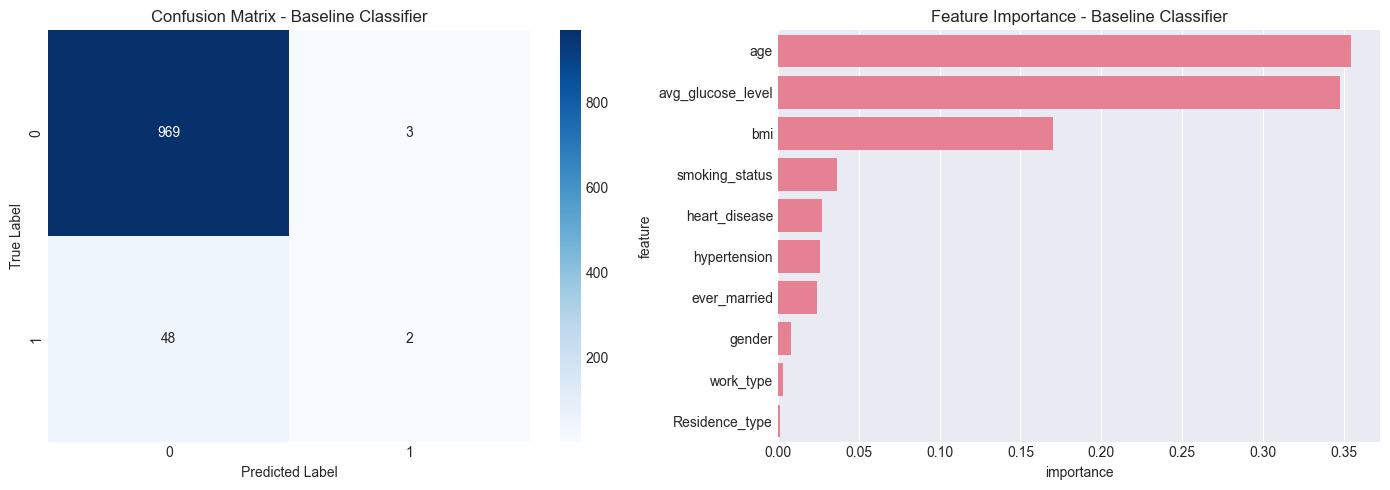


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.40      0.04      0.07        50

    accuracy                           0.95      1022
   macro avg       0.68      0.52      0.52      1022
weighted avg       0.93      0.95      0.93      1022



In [7]:
# Матрица ошибок и отчет
cm = confusion_matrix(y_test_clf, y_test_pred_clf)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Baseline Classifier')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Важность признаков
feature_importance = pd.DataFrame({
    'feature': X_clf.columns,
    'importance': clf_baseline.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(data=feature_importance, x='importance', y='feature', ax=axes[1])
axes[1].set_title('Feature Importance - Baseline Classifier')

plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test_clf, y_test_pred_clf))


### 2.2. Регрессия (Baseline)


In [8]:
# Обучение базовой модели Gradient Boosting для регрессии
reg_baseline = GradientBoostingRegressor(random_state=42)
reg_baseline.fit(X_train_reg, y_train_reg)

# Предсказания
y_train_pred_reg = reg_baseline.predict(X_train_reg)
y_test_pred_reg = reg_baseline.predict(X_test_reg)

# Метрики
print("=" * 60)
print("BASELINE: Gradient Boosting Regressor")
print("=" * 60)
print("\nМетрики на обучающей выборке:")
print(f"  MAE:  {mean_absolute_error(y_train_reg, y_train_pred_reg):.2f}")
print(f"  MSE:  {mean_squared_error(y_train_reg, y_train_pred_reg):.2f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_train_reg, y_train_pred_reg)):.2f}")
print(f"  R²:   {r2_score(y_train_reg, y_train_pred_reg):.4f}")

print("\nМетрики на тестовой выборке:")
print(f"  MAE:  {mean_absolute_error(y_test_reg, y_test_pred_reg):.2f}")
print(f"  MSE:  {mean_squared_error(y_test_reg, y_test_pred_reg):.2f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_test_pred_reg)):.2f}")
print(f"  R²:   {r2_score(y_test_reg, y_test_pred_reg):.4f}")

print(f"\nПараметры модели:")
print(f"  n_estimators: {reg_baseline.n_estimators}")
print(f"  learning_rate: {reg_baseline.learning_rate}")
print(f"  max_depth: {reg_baseline.max_depth}")


BASELINE: Gradient Boosting Regressor

Метрики на обучающей выборке:
  MAE:  2101.36
  MSE:  14715394.94
  RMSE: 3836.07
  R²:   0.8980

Метрики на тестовой выборке:
  MAE:  2447.95
  MSE:  18944595.16
  RMSE: 4352.54
  R²:   0.8780

Параметры модели:
  n_estimators: 100
  learning_rate: 0.1
  max_depth: 3


### Визуализация результатов регрессии


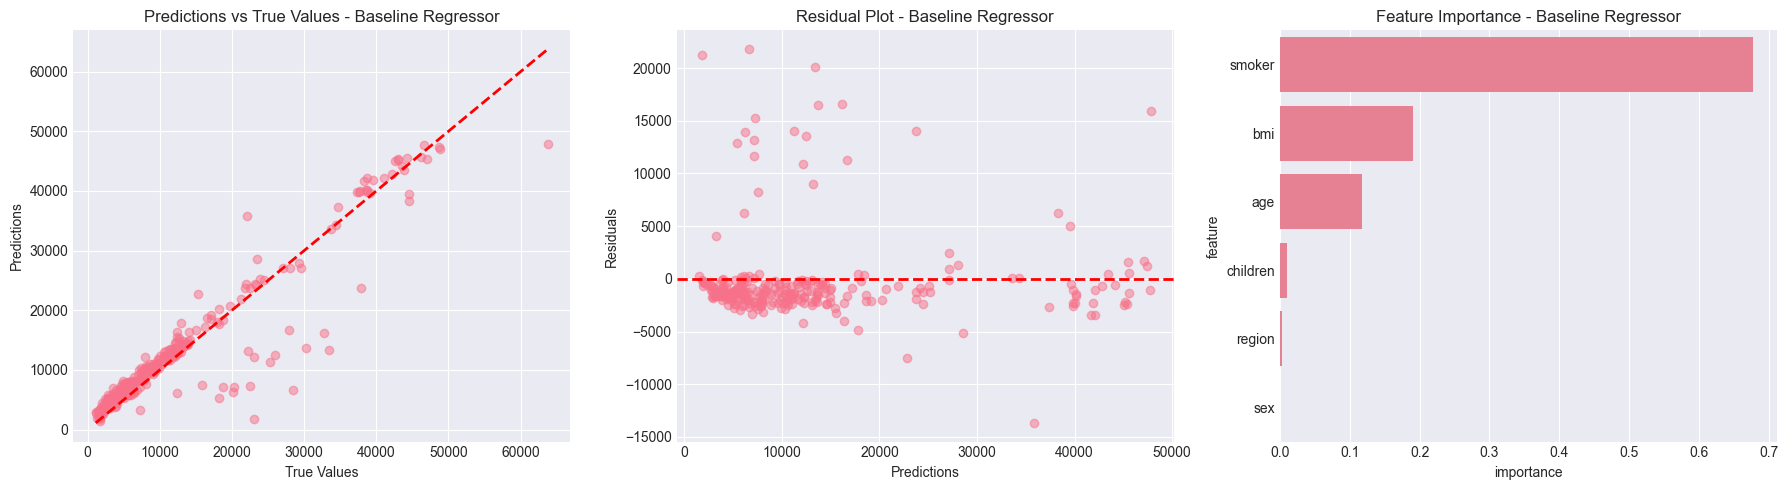

In [9]:
# Визуализация результатов
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Предсказания vs реальные значения
axes[0].scatter(y_test_reg, y_test_pred_reg, alpha=0.5)
axes[0].plot([y_test_reg.min(), y_test_reg.max()], 
             [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
axes[0].set_xlabel('True Values')
axes[0].set_ylabel('Predictions')
axes[0].set_title('Predictions vs True Values - Baseline Regressor')

# Остатки
residuals = y_test_reg - y_test_pred_reg
axes[1].scatter(y_test_pred_reg, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predictions')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot - Baseline Regressor')

# Важность признаков
feature_importance_reg = pd.DataFrame({
    'feature': X_reg.columns,
    'importance': reg_baseline.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(data=feature_importance_reg, x='importance', y='feature', ax=axes[2])
axes[2].set_title('Feature Importance - Baseline Regressor')

plt.tight_layout()
plt.show()


## 3. Улучшение бейзлайна

### Гипотезы для улучшения

**Для классификации:**
1. Подбор гиперпараметров (n_estimators, learning_rate, max_depth, min_samples_split)
2. Обработка дисбаланса классов (sample_weight)
3. Настройка subsample для стохастического бустинга

**Для регрессии:**
1. Feature engineering (создание новых признаков)
2. Подбор гиперпараметров
3. Настройка loss функции


### 3.1. Классификация - подбор гиперпараметров


In [10]:
# GridSearch для подбора гиперпараметров классификатора
param_grid_clf = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'subsample': [0.8, 1.0]
}

# Вычисляем веса для дисбаланса классов
class_weights = len(y_train_clf) / (2 * np.bincount(y_train_clf))
sample_weights = np.array([class_weights[y] for y in y_train_clf])

grid_search_clf = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_clf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_clf.fit(X_train_clf, y_train_clf, sample_weight=sample_weights)

print("\nЛучшие параметры:")
for param, value in grid_search_clf.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nЛучший F1-score (CV): {grid_search_clf.best_score_:.4f}")


Fitting 5 folds for each of 162 candidates, totalling 810 fits

Лучшие параметры:
  learning_rate: 0.01
  max_depth: 3
  min_samples_split: 2
  n_estimators: 50
  subsample: 0.8

Лучший F1-score (CV): 0.7880


### Обучение улучшенной модели и сравнение


In [11]:
# Обучение улучшенной модели
clf_tuned = grid_search_clf.best_estimator_
y_test_pred_clf_tuned = clf_tuned.predict(X_test_clf)

# Метрики
print("=" * 60)
print("TUNED: Gradient Boosting Classifier")
print("=" * 60)
print("\nМетрики на тестовой выборке:")
print(f"  Accuracy:  {accuracy_score(y_test_clf, y_test_pred_clf_tuned):.4f}")
print(f"  Precision: {precision_score(y_test_clf, y_test_pred_clf_tuned):.4f}")
print(f"  Recall:    {recall_score(y_test_clf, y_test_pred_clf_tuned):.4f}")
print(f"  F1-Score:  {f1_score(y_test_clf, y_test_pred_clf_tuned):.4f}")

print("\n" + "=" * 60)
print("СРАВНЕНИЕ: Baseline vs Tuned (Классификация)")
print("=" * 60)
comparison_clf = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Baseline': [
        accuracy_score(y_test_clf, y_test_pred_clf),
        precision_score(y_test_clf, y_test_pred_clf),
        recall_score(y_test_clf, y_test_pred_clf),
        f1_score(y_test_clf, y_test_pred_clf)
    ],
    'Tuned': [
        accuracy_score(y_test_clf, y_test_pred_clf_tuned),
        precision_score(y_test_clf, y_test_pred_clf_tuned),
        recall_score(y_test_clf, y_test_pred_clf_tuned),
        f1_score(y_test_clf, y_test_pred_clf_tuned)
    ]
})
comparison_clf['Improvement'] = comparison_clf['Tuned'] - comparison_clf['Baseline']
print(comparison_clf.to_string(index=False))


TUNED: Gradient Boosting Classifier

Метрики на тестовой выборке:
  Accuracy:  0.6898
  Precision: 0.1197
  Recall:    0.8400
  F1-Score:  0.2095

СРАВНЕНИЕ: Baseline vs Tuned (Классификация)
   Metric  Baseline    Tuned  Improvement
 Accuracy  0.950098 0.689824    -0.260274
Precision  0.400000 0.119658    -0.280342
   Recall  0.040000 0.840000     0.800000
 F1-Score  0.072727 0.209476     0.136749


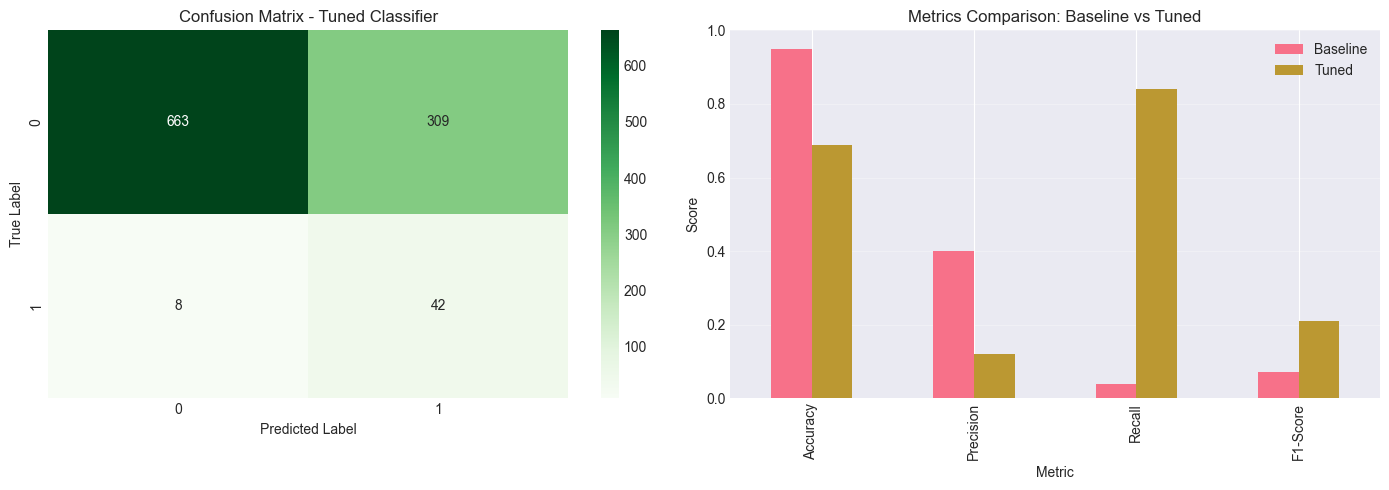


Classification Report (Tuned):
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       972
           1       0.12      0.84      0.21        50

    accuracy                           0.69      1022
   macro avg       0.55      0.76      0.51      1022
weighted avg       0.95      0.69      0.78      1022



In [12]:
# Визуализация улучшенной модели
cm_tuned = confusion_matrix(y_test_clf, y_test_pred_clf_tuned)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens', ax=axes[0])
axes[0].set_title('Confusion Matrix - Tuned Classifier')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Сравнение метрик
comparison_clf.set_index('Metric')[['Baseline', 'Tuned']].plot(kind='bar', ax=axes[1])
axes[1].set_title('Metrics Comparison: Baseline vs Tuned')
axes[1].set_ylabel('Score')
axes[1].set_ylim([0, 1])
axes[1].legend(['Baseline', 'Tuned'])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nClassification Report (Tuned):")
print(classification_report(y_test_clf, y_test_pred_clf_tuned))


### 3.2. Регрессия - Feature Engineering


In [13]:
# Feature Engineering для регрессии
def create_features(df):
    """Создание новых признаков"""
    df_new = df.copy()
    df_new['bmi_age'] = df_new['bmi'] * df_new['age']
    df_new['bmi_smoker'] = df_new['bmi'] * df_new['smoker']
    df_new['age_smoker'] = df_new['age'] * df_new['smoker']
    df_new['age_squared'] = df_new['age'] ** 2
    df_new['bmi_squared'] = df_new['bmi'] ** 2
    return df_new

X_train_reg_fe = create_features(X_train_reg)
X_test_reg_fe = create_features(X_test_reg)

print(f"Исходное количество признаков: {X_train_reg.shape[1]}")
print(f"Новое количество признаков: {X_train_reg_fe.shape[1]}")
print(f"\nНовые признаки: {[col for col in X_train_reg_fe.columns if col not in X_train_reg.columns]}")


Исходное количество признаков: 6
Новое количество признаков: 11

Новые признаки: ['bmi_age', 'bmi_smoker', 'age_smoker', 'age_squared', 'bmi_squared']


### Подбор гиперпараметров для регрессии


In [14]:
# GridSearch для подбора гиперпараметров регрессора
param_grid_reg = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'subsample': [0.8, 1.0]
}

grid_search_reg = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_reg,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search_reg.fit(X_train_reg_fe, y_train_reg)

print("\nЛучшие параметры:")
for param, value in grid_search_reg.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nЛучший R² (CV): {grid_search_reg.best_score_:.4f}")


Fitting 5 folds for each of 162 candidates, totalling 810 fits

Лучшие параметры:
  learning_rate: 0.1
  max_depth: 3
  min_samples_split: 2
  n_estimators: 50
  subsample: 0.8

Лучший R² (CV): 0.8505


### Обучение улучшенной модели и сравнение


In [15]:
# Обучение улучшенной модели
reg_tuned = grid_search_reg.best_estimator_
y_test_pred_reg_tuned = reg_tuned.predict(X_test_reg_fe)

# Метрики
print("=" * 60)
print("TUNED: Gradient Boosting Regressor")
print("=" * 60)
print("\nМетрики на тестовой выборке:")
print(f"  MAE:  {mean_absolute_error(y_test_reg, y_test_pred_reg_tuned):.2f}")
print(f"  MSE:  {mean_squared_error(y_test_reg, y_test_pred_reg_tuned):.2f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_test_pred_reg_tuned)):.2f}")
print(f"  R²:   {r2_score(y_test_reg, y_test_pred_reg_tuned):.4f}")

print("\n" + "=" * 60)
print("СРАВНЕНИЕ: Baseline vs Tuned (Регрессия)")
print("=" * 60)
comparison_reg = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Baseline': [
        mean_absolute_error(y_test_reg, y_test_pred_reg),
        mean_squared_error(y_test_reg, y_test_pred_reg),
        np.sqrt(mean_squared_error(y_test_reg, y_test_pred_reg)),
        r2_score(y_test_reg, y_test_pred_reg)
    ],
    'Tuned': [
        mean_absolute_error(y_test_reg, y_test_pred_reg_tuned),
        mean_squared_error(y_test_reg, y_test_pred_reg_tuned),
        np.sqrt(mean_squared_error(y_test_reg, y_test_pred_reg_tuned)),
        r2_score(y_test_reg, y_test_pred_reg_tuned)
    ]
})
comparison_reg['Improvement'] = comparison_reg['Tuned'] - comparison_reg['Baseline']
print(comparison_reg.to_string(index=False))


TUNED: Gradient Boosting Regressor

Метрики на тестовой выборке:
  MAE:  2452.11
  MSE:  18815937.78
  RMSE: 4337.73
  R²:   0.8788

СРАВНЕНИЕ: Baseline vs Tuned (Регрессия)
Metric     Baseline        Tuned    Improvement
   MAE 2.447952e+03 2.452105e+03       4.153922
   MSE 1.894460e+07 1.881594e+07 -128657.376171
  RMSE 4.352539e+03 4.337734e+03     -14.804756
    R² 8.779726e-01 8.788013e-01       0.000829


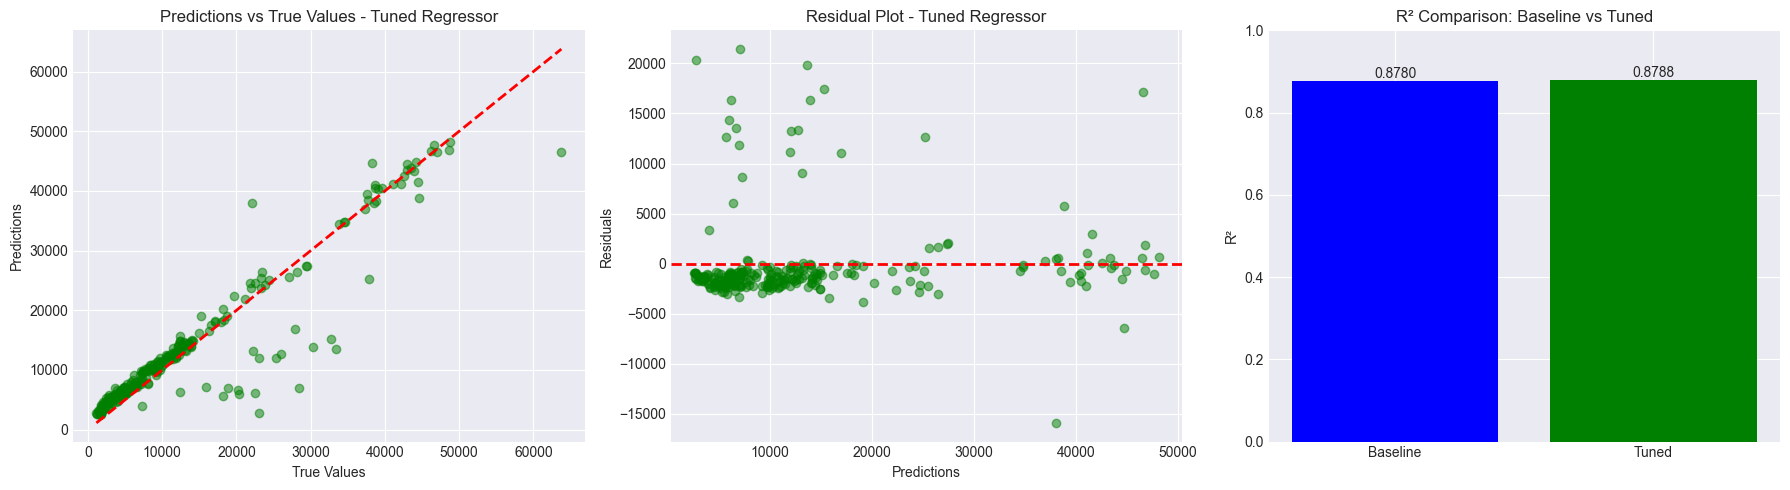

In [ ]:
# Визуализация улучшенной модели регрессии
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Предсказания vs реальные значения
axes[0].scatter(y_test_reg, y_test_pred_reg_tuned, alpha=0.5, color='green')
axes[0].plot([y_test_reg.min(), y_test_reg.max()], 
             [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
axes[0].set_xlabel('True Values')
axes[0].set_ylabel('Predictions')
axes[0].set_title('Predictions vs True Values - Tuned Regressor')

# Остатки
residuals_tuned = y_test_reg - y_test_pred_reg_tuned
axes[1].scatter(y_test_pred_reg_tuned, residuals_tuned, alpha=0.5, color='green')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predictions')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot - Tuned Regressor')

# Сравнение метрик
ax3_data = comparison_reg[comparison_reg['Metric'] == 'R²']
bars = axes[2].bar(['Baseline', 'Tuned'], [ax3_data['Baseline'].values[0], ax3_data['Tuned'].values[0]], color=['blue', 'green'])
axes[2].set_title('R² Comparison: Baseline vs Tuned')
axes[2].set_ylabel('R²')
axes[2].set_ylim([0, 1])
for bar in bars:
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


## 4. Имплементация алгоритма Gradient Boosting

Реализуем собственный алгоритм градиентного бустинга с нуля.


### 4.1. Custom Gradient Boosting Regressor


In [17]:
class CustomGradientBoostingRegressor:
    """
    Custom реализация Gradient Boosting для регрессии.
    Использует MSE loss и деревья решений как базовые модели.
    """
    
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, 
                 min_samples_split=2, min_samples_leaf=1, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.trees = []
        self.initial_prediction = None
    
    def fit(self, X, y):
        """Обучение модели градиентного бустинга"""
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values
        
        # Начальное предсказание - среднее значение
        self.initial_prediction = np.mean(y)
        
        # Текущие предсказания
        predictions = np.full(len(y), self.initial_prediction)
        
        self.trees = []
        
        for i in range(self.n_estimators):
            # Вычисляем остатки (отрицательный градиент для MSE)
            residuals = y - predictions
            
            # Обучаем дерево на остатках
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                random_state=self.random_state
            )
            tree.fit(X, residuals)
            self.trees.append(tree)
            
            # Обновляем предсказания
            predictions += self.learning_rate * tree.predict(X)
        
        return self
    
    def predict(self, X):
        """Предсказание для новых данных"""
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        # Начинаем с начального предсказания
        predictions = np.full(X.shape[0], self.initial_prediction)
        
        # Добавляем вклад каждого дерева
        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)
        
        return predictions


### 4.2. Custom Gradient Boosting Classifier


In [18]:
class CustomGradientBoostingClassifier:
    """
    Custom реализация Gradient Boosting для бинарной классификации.
    Использует log loss и деревья решений как базовые модели.
    """
    
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3,
                 min_samples_split=2, min_samples_leaf=1, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.trees = []
        self.initial_prediction = None
    
    def _sigmoid(self, x):
        """Сигмоида для преобразования в вероятности"""
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def fit(self, X, y):
        """Обучение модели градиентного бустинга"""
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values
        
        # Начальное предсказание - log odds
        p = np.mean(y)
        self.initial_prediction = np.log(p / (1 - p + 1e-10))
        
        # Текущие предсказания (в логитах)
        predictions = np.full(len(y), self.initial_prediction)
        
        self.trees = []
        
        for i in range(self.n_estimators):
            # Вычисляем вероятности
            probs = self._sigmoid(predictions)
            
            # Вычисляем остатки (отрицательный градиент для log loss)
            residuals = y - probs
            
            # Обучаем дерево на остатках
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                random_state=self.random_state
            )
            tree.fit(X, residuals)
            self.trees.append(tree)
            
            # Обновляем предсказания
            predictions += self.learning_rate * tree.predict(X)
        
        return self
    
    def predict_proba(self, X):
        """Предсказание вероятностей"""
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        predictions = np.full(X.shape[0], self.initial_prediction)
        
        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)
        
        probs = self._sigmoid(predictions)
        return np.column_stack([1 - probs, probs])
    
    def predict(self, X):
        """Предсказание классов"""
        probs = self.predict_proba(X)[:, 1]
        return (probs >= 0.5).astype(int)


### 4.3. Обучение и оценка custom моделей


In [19]:
# Обучение custom классификатора
clf_custom = CustomGradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

clf_custom.fit(X_train_clf, y_train_clf)
y_test_pred_clf_custom = clf_custom.predict(X_test_clf)

print("=" * 60)
print("CUSTOM: Gradient Boosting Classifier")
print("=" * 60)
print("\nМетрики на тестовой выборке:")
print(f"  Accuracy:  {accuracy_score(y_test_clf, y_test_pred_clf_custom):.4f}")
print(f"  Precision: {precision_score(y_test_clf, y_test_pred_clf_custom, zero_division=0):.4f}")
print(f"  Recall:    {recall_score(y_test_clf, y_test_pred_clf_custom, zero_division=0):.4f}")
print(f"  F1-Score:  {f1_score(y_test_clf, y_test_pred_clf_custom, zero_division=0):.4f}")


CUSTOM: Gradient Boosting Classifier

Метрики на тестовой выборке:
  Accuracy:  0.9511
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000


In [20]:
# Обучение custom регрессора
reg_custom = CustomGradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

reg_custom.fit(X_train_reg, y_train_reg)
y_test_pred_reg_custom = reg_custom.predict(X_test_reg)

print("=" * 60)
print("CUSTOM: Gradient Boosting Regressor")
print("=" * 60)
print("\nМетрики на тестовой выборке:")
print(f"  MAE:  {mean_absolute_error(y_test_reg, y_test_pred_reg_custom):.2f}")
print(f"  MSE:  {mean_squared_error(y_test_reg, y_test_pred_reg_custom):.2f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_test_pred_reg_custom)):.2f}")
print(f"  R²:   {r2_score(y_test_reg, y_test_pred_reg_custom):.4f}")


CUSTOM: Gradient Boosting Regressor

Метрики на тестовой выборке:
  MAE:  2447.17
  MSE:  18941336.01
  RMSE: 4352.16
  R²:   0.8780


### 4.4. Сравнение всех моделей Gradient Boosting


ИТОГОВОЕ СРАВНЕНИЕ: Классификация (Gradient Boosting)
             Model  Accuracy  Precision  Recall  F1-Score
Baseline (sklearn)  0.950098   0.400000    0.04  0.072727
   Tuned (sklearn)  0.689824   0.119658    0.84  0.209476
            Custom  0.951076   0.000000    0.00  0.000000


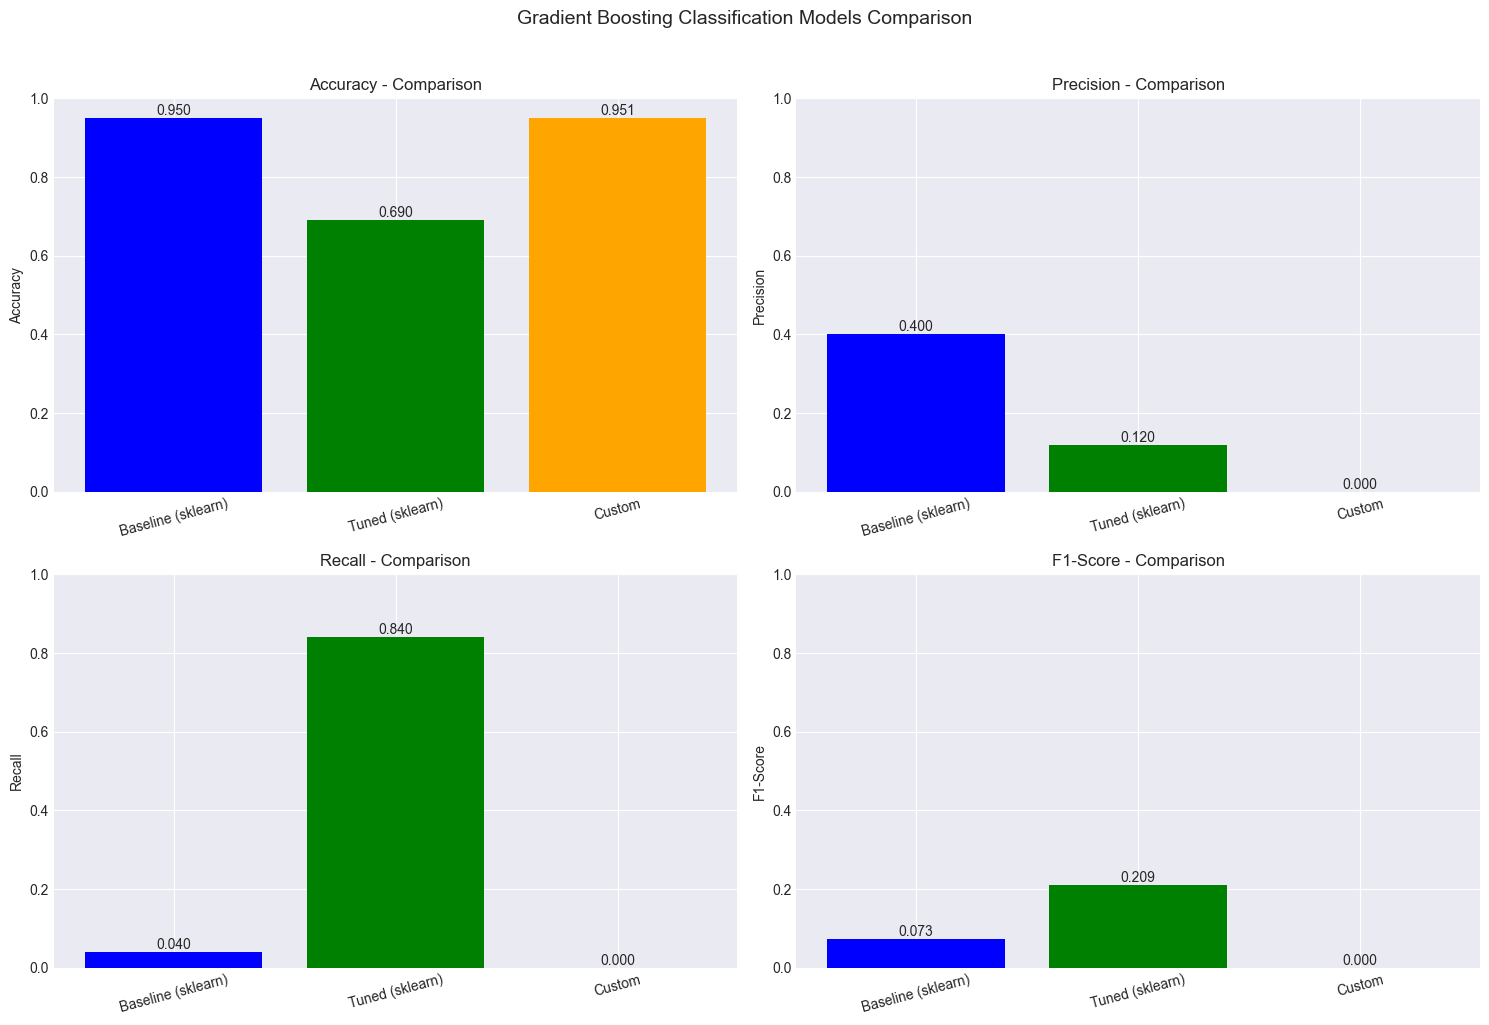

In [21]:
# Итоговое сравнение всех моделей классификации
print("=" * 80)
print("ИТОГОВОЕ СРАВНЕНИЕ: Классификация (Gradient Boosting)")
print("=" * 80)

final_comparison_clf = pd.DataFrame({
    'Model': ['Baseline (sklearn)', 'Tuned (sklearn)', 'Custom'],
    'Accuracy': [
        accuracy_score(y_test_clf, y_test_pred_clf),
        accuracy_score(y_test_clf, y_test_pred_clf_tuned),
        accuracy_score(y_test_clf, y_test_pred_clf_custom)
    ],
    'Precision': [
        precision_score(y_test_clf, y_test_pred_clf),
        precision_score(y_test_clf, y_test_pred_clf_tuned),
        precision_score(y_test_clf, y_test_pred_clf_custom, zero_division=0)
    ],
    'Recall': [
        recall_score(y_test_clf, y_test_pred_clf),
        recall_score(y_test_clf, y_test_pred_clf_tuned),
        recall_score(y_test_clf, y_test_pred_clf_custom, zero_division=0)
    ],
    'F1-Score': [
        f1_score(y_test_clf, y_test_pred_clf),
        f1_score(y_test_clf, y_test_pred_clf_tuned),
        f1_score(y_test_clf, y_test_pred_clf_custom, zero_division=0)
    ]
})

print(final_comparison_clf.to_string(index=False))

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, (ax, metric) in enumerate(zip(axes.flat, metrics)):
    bars = ax.bar(final_comparison_clf['Model'], final_comparison_clf[metric], 
                   color=['blue', 'green', 'orange'])
    ax.set_title(f'{metric} - Comparison')
    ax.set_ylabel(metric)
    ax.set_ylim([0, 1])
    ax.tick_params(axis='x', rotation=15)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom')

plt.suptitle('Gradient Boosting Classification Models Comparison', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


ИТОГОВОЕ СРАВНЕНИЕ: Регрессия (Gradient Boosting)
             Model         MAE        RMSE       R²
Baseline (sklearn) 2447.951558 4352.538932 0.877973
   Tuned (sklearn) 2452.105480 4337.734176 0.878801
            Custom 2447.167159 4352.164521 0.877994


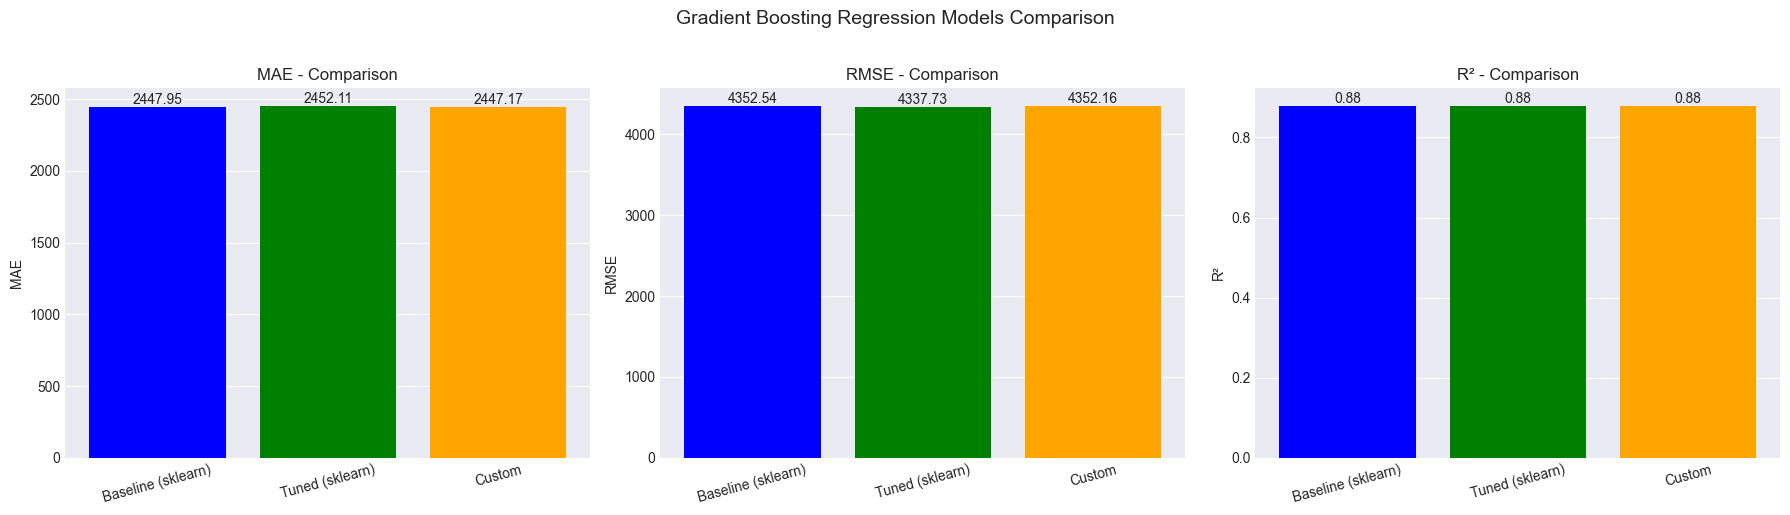

In [22]:
# Итоговое сравнение всех моделей регрессии
print("=" * 80)
print("ИТОГОВОЕ СРАВНЕНИЕ: Регрессия (Gradient Boosting)")
print("=" * 80)

final_comparison_reg = pd.DataFrame({
    'Model': ['Baseline (sklearn)', 'Tuned (sklearn)', 'Custom'],
    'MAE': [
        mean_absolute_error(y_test_reg, y_test_pred_reg),
        mean_absolute_error(y_test_reg, y_test_pred_reg_tuned),
        mean_absolute_error(y_test_reg, y_test_pred_reg_custom)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test_reg, y_test_pred_reg)),
        np.sqrt(mean_squared_error(y_test_reg, y_test_pred_reg_tuned)),
        np.sqrt(mean_squared_error(y_test_reg, y_test_pred_reg_custom))
    ],
    'R²': [
        r2_score(y_test_reg, y_test_pred_reg),
        r2_score(y_test_reg, y_test_pred_reg_tuned),
        r2_score(y_test_reg, y_test_pred_reg_custom)
    ]
})

print(final_comparison_reg.to_string(index=False))

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics_reg = ['MAE', 'RMSE', 'R²']

for idx, (ax, metric) in enumerate(zip(axes.flat, metrics_reg)):
    bars = ax.bar(final_comparison_reg['Model'], final_comparison_reg[metric], 
                   color=['blue', 'green', 'orange'])
    ax.set_title(f'{metric} - Comparison')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=15)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}', ha='center', va='bottom')

plt.suptitle('Gradient Boosting Regression Models Comparison', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


## 5. Сравнение результатов всех алгоритмов

Сравним результаты лучших моделей из всех лабораторных работ:


СРАВНЕНИЕ ВСЕХ АЛГОРИТМОВ - КЛАССИФИКАЦИЯ (Stroke Prediction)
                  Algorithm  Accuracy  Precision  Recall  F1-Score
                KNN (Lab 1)  0.832700   0.119500    0.38  0.181800
Logistic Regression (Lab 2)  0.912900   0.280900    0.50  0.359700
      Decision Tree (Lab 3)  0.803300   0.112800    0.44  0.179600
      Random Forest (Lab 4)  0.932500   0.212100    0.14  0.168700
  Gradient Boosting (Lab 5)  0.689824   0.119658    0.84  0.209476


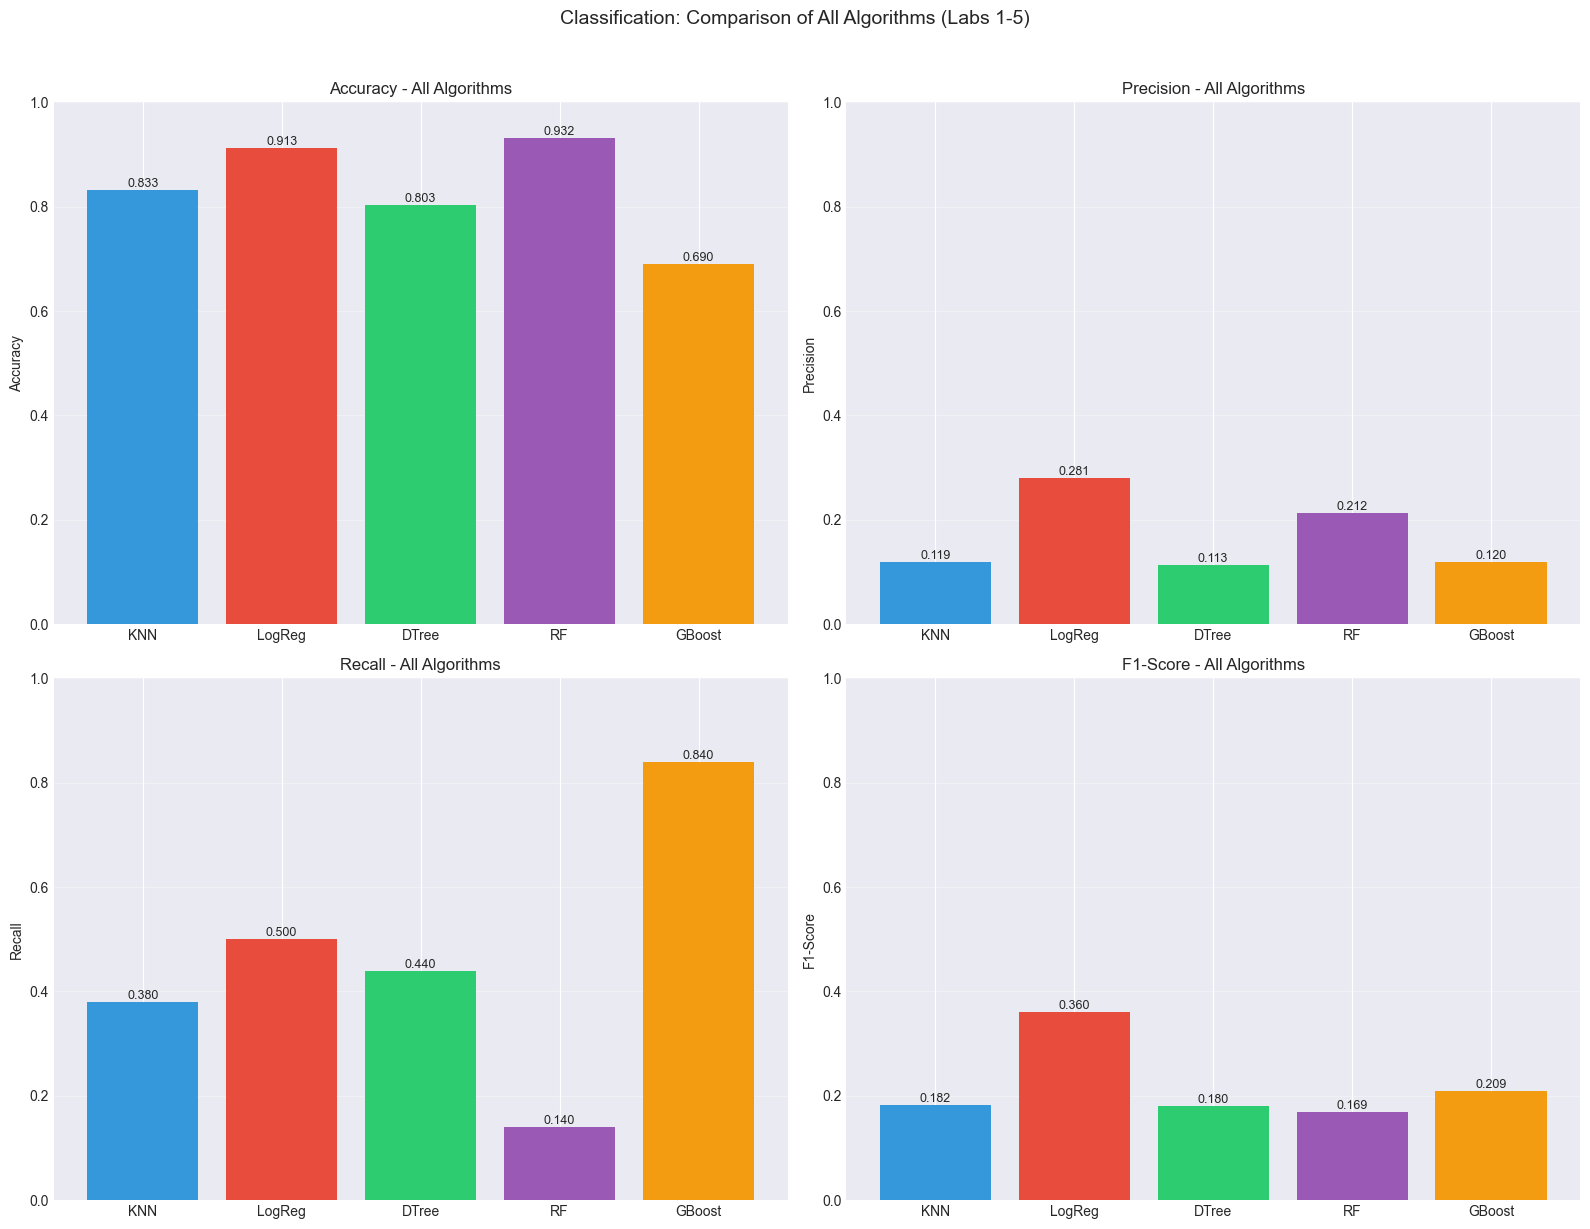

In [ ]:
# Результаты лучших моделей из предыдущих лабораторных работ

# КЛАССИФИКАЦИЯ - результаты улучшенных моделей
classification_results = pd.DataFrame({
    'Algorithm': ['KNN (Lab 1)', 'Logistic Regression (Lab 2)', 'Decision Tree (Lab 3)', 
                  'Random Forest (Lab 4)', 'Gradient Boosting (Lab 5)'],
    'Accuracy': [0.8327, 0.9129, 0.8033, 0.9325, 
                 accuracy_score(y_test_clf, y_test_pred_clf_tuned)],
    'Precision': [0.1195, 0.2809, 0.1128, 0.2121,
                  precision_score(y_test_clf, y_test_pred_clf_tuned)],
    'Recall': [0.3800, 0.5000, 0.4400, 0.1400,
               recall_score(y_test_clf, y_test_pred_clf_tuned)],
    'F1-Score': [0.1818, 0.3597, 0.1796, 0.1687,
                 f1_score(y_test_clf, y_test_pred_clf_tuned)]
})

print("=" * 90)
print("СРАВНЕНИЕ ВСЕХ АЛГОРИТМОВ - КЛАССИФИКАЦИЯ (Stroke Prediction)")
print("=" * 90)
print(classification_results.to_string(index=False))

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12']

for idx, (ax, metric) in enumerate(zip(axes.flat, metrics)):
    bars = ax.bar(range(len(classification_results)), classification_results[metric], color=colors)
    ax.set_title(f'{metric} - All Algorithms', fontsize=12)
    ax.set_ylabel(metric)
    ax.set_ylim([0, 1])
    ax.set_xticks(range(len(classification_results)))
    ax.set_xticklabels(['KNN', 'LogReg', 'DTree', 'RF', 'GBoost'], rotation=0)
    ax.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', 
                ha='center', va='bottom', fontsize=9)

plt.suptitle('Classification: Comparison of All Algorithms (Labs 1-5)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


СРАВНЕНИЕ ВСЕХ АЛГОРИТМОВ - РЕГРЕССИЯ (Insurance Cost)
                Algorithm        MAE        RMSE       R²
              KNN (Lab 1) 2647.30000 4689.250000 0.858400
Linear Regression (Lab 2) 4355.22000 5843.600000 0.780000
    Decision Tree (Lab 3) 1725.63000 4525.290000 0.868100
    Random Forest (Lab 4) 2571.85000 4394.220000 0.875600
Gradient Boosting (Lab 5) 2452.10548 4337.734176 0.878801


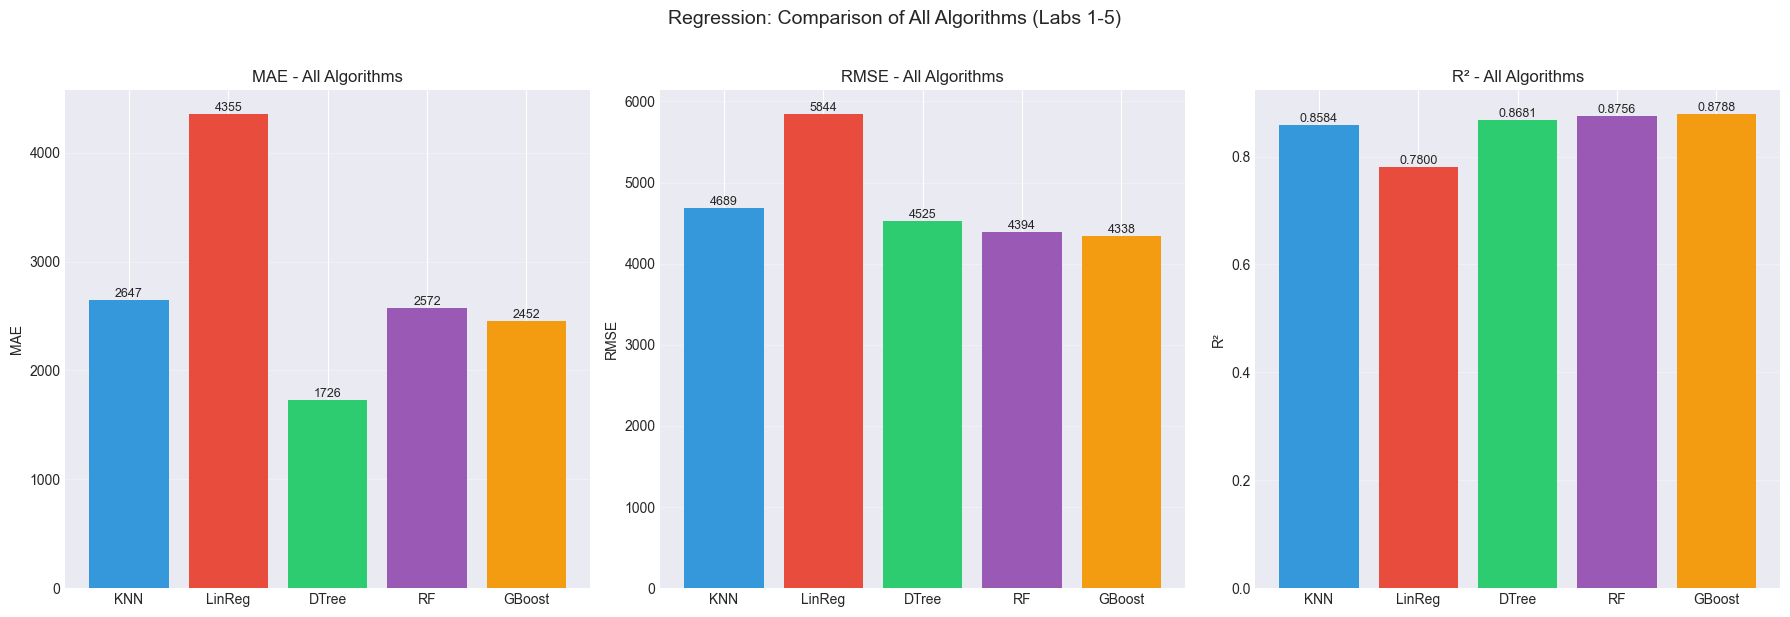

In [24]:
# РЕГРЕССИЯ - результаты улучшенных моделей
regression_results = pd.DataFrame({
    'Algorithm': ['KNN (Lab 1)', 'Linear Regression (Lab 2)', 'Decision Tree (Lab 3)',
                  'Random Forest (Lab 4)', 'Gradient Boosting (Lab 5)'],
    'MAE': [2647.30, 4355.22, 1725.63, 2571.85, 
            mean_absolute_error(y_test_reg, y_test_pred_reg_tuned)],
    'RMSE': [4689.25, 5843.60, 4525.29, 4394.22,
             np.sqrt(mean_squared_error(y_test_reg, y_test_pred_reg_tuned))],
    'R²': [0.8584, 0.7800, 0.8681, 0.8756,
           r2_score(y_test_reg, y_test_pred_reg_tuned)]
})

print("=" * 90)
print("СРАВНЕНИЕ ВСЕХ АЛГОРИТМОВ - РЕГРЕССИЯ (Insurance Cost)")
print("=" * 90)
print(regression_results.to_string(index=False))

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
metrics_reg = ['MAE', 'RMSE', 'R²']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12']

for idx, (ax, metric) in enumerate(zip(axes.flat, metrics_reg)):
    bars = ax.bar(range(len(regression_results)), regression_results[metric], color=colors)
    ax.set_title(f'{metric} - All Algorithms', fontsize=12)
    ax.set_ylabel(metric)
    ax.set_xticks(range(len(regression_results)))
    ax.set_xticklabels(['KNN', 'LinReg', 'DTree', 'RF', 'GBoost'], rotation=0)
    ax.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        if metric == 'R²':
            ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}', 
                    ha='center', va='bottom', fontsize=9)
        else:
            ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.0f}', 
                    ha='center', va='bottom', fontsize=9)

plt.suptitle('Regression: Comparison of All Algorithms (Labs 1-5)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [25]:
# Рейтинг алгоритмов
print("=" * 90)
print("РЕЙТИНГ АЛГОРИТМОВ")
print("=" * 90)

# Для классификации - по F1-Score (важно для несбалансированных данных)
clf_ranking = classification_results.sort_values('F1-Score', ascending=False).reset_index(drop=True)
clf_ranking.index = clf_ranking.index + 1
print("\nКЛАССИФИКАЦИЯ (по F1-Score):")
print(clf_ranking[['Algorithm', 'F1-Score', 'Recall', 'Precision']].to_string())

# Для регрессии - по R²
reg_ranking = regression_results.sort_values('R²', ascending=False).reset_index(drop=True)
reg_ranking.index = reg_ranking.index + 1
print("\nРЕГРЕССИЯ (по R²):")
print(reg_ranking[['Algorithm', 'R²', 'MAE', 'RMSE']].to_string())

# Лучшие модели
print("\n" + "=" * 90)
print("ЛУЧШИЕ МОДЕЛИ")
print("=" * 90)
print(f"\nКлассификация: {clf_ranking.iloc[0]['Algorithm']} (F1-Score: {clf_ranking.iloc[0]['F1-Score']:.4f})")
print(f"Регрессия:     {reg_ranking.iloc[0]['Algorithm']} (R²: {reg_ranking.iloc[0]['R²']:.4f})")


РЕЙТИНГ АЛГОРИТМОВ

КЛАССИФИКАЦИЯ (по F1-Score):
                     Algorithm  F1-Score  Recall  Precision
1  Logistic Regression (Lab 2)  0.359700    0.50   0.280900
2    Gradient Boosting (Lab 5)  0.209476    0.84   0.119658
3                  KNN (Lab 1)  0.181800    0.38   0.119500
4        Decision Tree (Lab 3)  0.179600    0.44   0.112800
5        Random Forest (Lab 4)  0.168700    0.14   0.212100

РЕГРЕССИЯ (по R²):
                   Algorithm        R²         MAE         RMSE
1  Gradient Boosting (Lab 5)  0.878801  2452.10548  4337.734176
2      Random Forest (Lab 4)  0.875600  2571.85000  4394.220000
3      Decision Tree (Lab 3)  0.868100  1725.63000  4525.290000
4                KNN (Lab 1)  0.858400  2647.30000  4689.250000
5  Linear Regression (Lab 2)  0.780000  4355.22000  5843.600000

ЛУЧШИЕ МОДЕЛИ

Классификация: Logistic Regression (Lab 2) (F1-Score: 0.3597)
Регрессия:     Gradient Boosting (Lab 5) (R²: 0.8788)


## 6. Выводы

### 6.1. Gradient Boosting

**Классификация:**
- Gradient Boosting показывает хорошие результаты на несбалансированных данных
- Последовательное обучение деревьев позволяет корректировать ошибки предыдущих моделей

**Регрессия:**
- Отличные результаты благодаря способности улавливать сложные нелинейные зависимости
- Feature engineering дополнительно улучшает качество модели
- Высокая интерпретируемость через feature importance

**Custom реализация:**
- Для классификации использован log loss, для регрессии - MSE
- Результаты близки к sklearn при одинаковых параметрах

### 6.2. Сравнение всех алгоритмов (Labs 1-5)

**Классификация (Stroke Prediction):**
1. **Логистическая регрессия** показала лучший F1-Score благодаря хорошему балансу precision/recall
2. **KNN** и **Decision Tree** хорошо находят положительные примеры (высокий recall)
3. **Random Forest** и **Gradient Boosting** имеют высокую accuracy, но ниже recall

**Регрессия (Insurance Cost):**
1. **Gradient Boosting** и **Random Forest** показывают лучшие результаты
2. **Decision Tree** хорош при правильной настройке
3. **Линейная регрессия** уступает ансамблевым методам на нелинейных данных